<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/useful/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install exchange_calendars
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import requests
import datetime
import exchange_calendars as ecals # 개장일만
from io import StringIO
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import random
import seaborn as sns

In [32]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [42]:
class StockAnalyzer():
  def __init__(self, code='005930',period=365, sample_num=500, variables=[]):
    self.code = code
    self.period = period
    self.sample_num = sample_num

    self.start, self.today = self.get_date()
    self.df = self.get_df()
    self.mean, self.std = self.get_stats()

    self.model = self.get_simulation()



  def get_date(self):
    today = datetime.date.today().strftime('%Y%m%d')
    start = (datetime.date.today() - datetime.timedelta(days=self.period)).strftime('%Y%m%d')

    if XKRX.is_session(today) == False:
      today = XKRX.previous_open(today).strftime('%Y%m%d')
    if XKRX.is_session(start) == False:
      start = XKRX.next_open(start).strftime('%Y%m%d')
    return start, today
  
  def get_df(self):
    df = fdr.DataReader(self.code, self.start, self.today)
    df['Change'] += 1
    return df
  
  def get_stats(self):
    return self.df['Change'].mean(), self.df['Change'].std()

  # type: mc, cbb
  def get_simulation(self, sim_type='mc'):
    dates = XKRX.sessions_window(self.today, 249)
    if sim_type == 'mc':      
      close_li = [pd.DataFrame({'Change':[random.gauss(self.mean, self.std) for i in dates]}, index=dates) for x in range(self.sample_num)]
      self.model = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * self.df['Close'][-1], close_li))

    if sim_type == 'cbb':
      block = round(self.period ** (1/2))
      data = list(self.df['Change'][-self.period:].values)
      ccb = [(data+data[:block])[x:block+x] for x in range(len(data))]

      change = [j for sub in random.sample(ccb, int(self.period/block)) for j in sub]

      periods = len(change)
      dates = self.df[self.df.index > self.today].index[:periods]
      close_li = [pd.DataFrame({'Change':[j for sub in random.sample(ccb, int(periods/block)) for j in sub]}, index=dates) for x in range(self.sample_num)]
      self.model = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * self.df['Close'][-1], close_li))

    return self.model

  def plot_simulation(self):
      fig = plt.figure(figsize=(16, 8))
      ax = plt.subplot(111)
      colors = list(sns.color_palette("hls", self.sample_num).as_hex())
      for i, j in enumerate(self.model):
        ax.plot(j['Close'], color=colors[i]) #, label=i+1)
      plt.show()

  def plot_distribution(self):
    plt.figure(figsize=(16, 8))
    end_data = [x.iloc[-1].values[0] for x in self.model]
    plt.hist(end_data, bins=250)
    plt.show()


In [43]:
sa = StockAnalyzer()

In [45]:
t = sa.get_simulation()

In [52]:
t = pd.concat(t, axis=1)
t

,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
2023-04-11,66322.610284,65818.193387,65538.904343,65055.779731,65968.229702,64746.707723,64017.078658,66562.780682,64377.534952,65930.719807,...,66128.220986,65508.604062,65371.989911,65202.200772,67898.473531,65173.454578,66521.433420,65940.522277,66467.201060,65775.585388
2023-04-12,66810.060737,64194.092031,66530.830711,63724.509312,64605.757513,65210.979430,65589.180498,65913.838960,63149.417731,64688.672895,...,65642.538277,64665.283721,66254.915033,65780.842846,67120.595540,64357.395498,65100.131697,65730.147070,65605.008654,65737.752569
2023-04-13,65736.604434,64559.472370,66957.749486,63219.006206,64185.832254,63985.367181,65939.641296,67137.856183,64018.835636,64932.116395,...,64363.572588,63530.881724,65039.493759,65116.801205,65488.610939,65760.589583,64132.426788,65863.464631,66013.064841,65425.573949
2023-04-14,63573.647493,63032.045094,66031.778443,63357.723242,65132.252144,64642.633310,65540.807167,67059.153558,62197.136621,65036.694312,...,65740.690340,64189.851819,64630.833018,65283.120623,65775.791607,66847.972330,65718.486235,64976.787759,66502.604142,65730.143314
2023-04-17,64831.371163,64352.181164,66946.097334,63942.577332,65980.035621,65248.767710,65879.255553,68274.936286,61891.161709,64097.904331,...,66920.780430,67582.952792,64781.100590,66773.261849,66574.612904,66127.274933,65387.162197,63997.115497,67895.875643,64516.799578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,61911.180786,57134.076022,97141.495068,78960.572826,100965.966609,75781.533214,63416.263963,90330.364182,52267.094527,56577.844354,...,54517.664966,96856.522261,59983.719430,65140.799030,142860.813038,62489.483827,68479.674813,64453.465559,62034.217548,75891.744926
2024-04-08,62013.170579,57691.320589,97935.173926,78947.112462,103016.532591,76453.615743,62196.506169,89026.798326,52403.885491,56542.091581,...,53109.090279,96373.413738,60466.117772,66541.885612,142115.372412,63292.552186,66019.326028,65471.153011,60506.661676,76117.658194
2024-04-09,62248.657674,58091.341212,98933.612237,78959.859181,102679.282459,76889.855444,62200.767073,87667.704071,52611.288946,57100.849099,...,53864.272101,96343.108844,59525.930341,67280.771665,142357.815886,63352.078060,65828.937551,67209.092377,61237.049269,77175.657241
2024-04-10,61684.549054,58507.687659,99352.467114,79592.989796,105054.041190,76571.315929,61555.877733,86549.762463,51546.312675,57402.988727,...,55259.254397,97543.271288,59857.292085,68765.858738,136505.759549,64543.981431,67470.953284,65605.549785,61539.615895,77802.198258


In [53]:
t.columns = np.arange(len(t.columns))

In [54]:
t


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
2023-04-11,66322.610284,65818.193387,65538.904343,65055.779731,65968.229702,64746.707723,64017.078658,66562.780682,64377.534952,65930.719807,...,66128.220986,65508.604062,65371.989911,65202.200772,67898.473531,65173.454578,66521.433420,65940.522277,66467.201060,65775.585388
2023-04-12,66810.060737,64194.092031,66530.830711,63724.509312,64605.757513,65210.979430,65589.180498,65913.838960,63149.417731,64688.672895,...,65642.538277,64665.283721,66254.915033,65780.842846,67120.595540,64357.395498,65100.131697,65730.147070,65605.008654,65737.752569
2023-04-13,65736.604434,64559.472370,66957.749486,63219.006206,64185.832254,63985.367181,65939.641296,67137.856183,64018.835636,64932.116395,...,64363.572588,63530.881724,65039.493759,65116.801205,65488.610939,65760.589583,64132.426788,65863.464631,66013.064841,65425.573949
2023-04-14,63573.647493,63032.045094,66031.778443,63357.723242,65132.252144,64642.633310,65540.807167,67059.153558,62197.136621,65036.694312,...,65740.690340,64189.851819,64630.833018,65283.120623,65775.791607,66847.972330,65718.486235,64976.787759,66502.604142,65730.143314
2023-04-17,64831.371163,64352.181164,66946.097334,63942.577332,65980.035621,65248.767710,65879.255553,68274.936286,61891.161709,64097.904331,...,66920.780430,67582.952792,64781.100590,66773.261849,66574.612904,66127.274933,65387.162197,63997.115497,67895.875643,64516.799578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,61911.180786,57134.076022,97141.495068,78960.572826,100965.966609,75781.533214,63416.263963,90330.364182,52267.094527,56577.844354,...,54517.664966,96856.522261,59983.719430,65140.799030,142860.813038,62489.483827,68479.674813,64453.465559,62034.217548,75891.744926
2024-04-08,62013.170579,57691.320589,97935.173926,78947.112462,103016.532591,76453.615743,62196.506169,89026.798326,52403.885491,56542.091581,...,53109.090279,96373.413738,60466.117772,66541.885612,142115.372412,63292.552186,66019.326028,65471.153011,60506.661676,76117.658194
2024-04-09,62248.657674,58091.341212,98933.612237,78959.859181,102679.282459,76889.855444,62200.767073,87667.704071,52611.288946,57100.849099,...,53864.272101,96343.108844,59525.930341,67280.771665,142357.815886,63352.078060,65828.937551,67209.092377,61237.049269,77175.657241
2024-04-10,61684.549054,58507.687659,99352.467114,79592.989796,105054.041190,76571.315929,61555.877733,86549.762463,51546.312675,57402.988727,...,55259.254397,97543.271288,59857.292085,68765.858738,136505.759549,64543.981431,67470.953284,65605.549785,61539.615895,77802.198258


In [ ]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
monte_mean = np.mean([round(x.iloc[-1].values[0],0) for x in close_li])
print('Mean: ', monte_mean)

# 중앙
monte_median = np.median([round(x.iloc[-1].values[0],0) for x in close_li])
print('Median: ', monte_median)

95% Min:  68290
95% Max:  69494
Mean:  68891.901
Median:  68110.0


In [ ]:
monte_date = close_li[0].index[-1]

Circular Block Bootstrap

In [ ]:
block = round(periods ** (1/2))
data = list(test_df['Change'][-periods:].values)
ccb = [(data+data[:block])[x:block+x] for x in range(len(data))]

In [ ]:
import random

change = [j for sub in random.sample(ccb, int(periods/block)) for j in sub]

periods = len(change)
dates = df[df.index > end_date].index[:periods]
close_li = [pd.DataFrame({'Change':[j for sub in random.sample(ccb, int(periods/block)) for j in sub]}, index=dates) for x in range(sample_num)]
close_li = list(map(lambda x: np.cumprod(x).rename(columns={'Change':'Close'}) * test_df['Close'][-1], close_li))

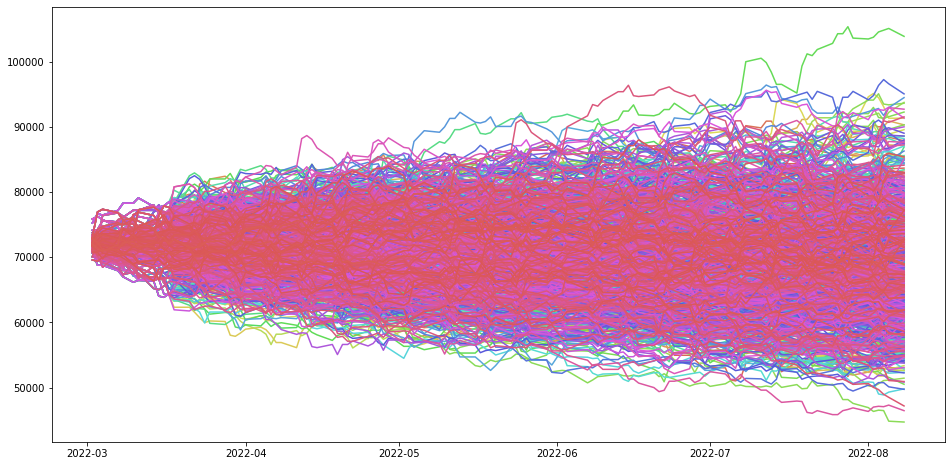

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)
colors = list(sns.color_palette("hls", sample_num).as_hex())

for i, j in enumerate(close_li):
  ax.plot(j['Close'], color=colors[i]) #, label=i+1)

plt.show()

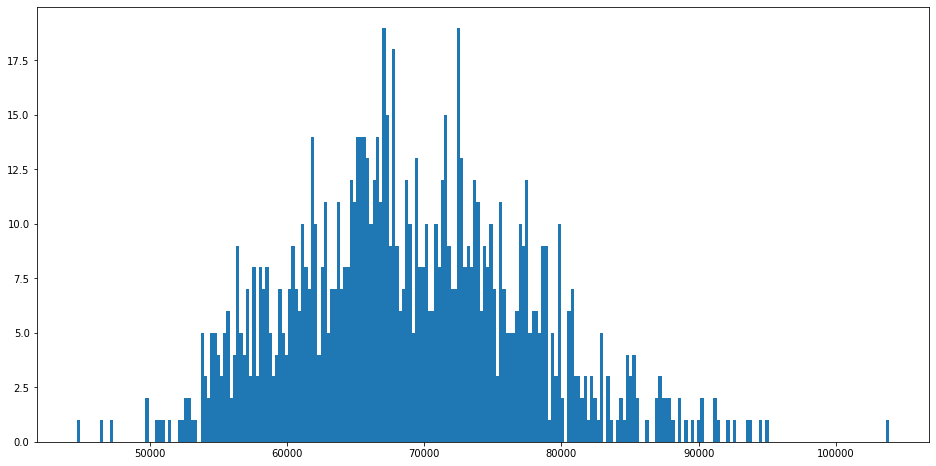

In [ ]:
plt.figure(figsize=(16, 8))
end_data = [x.iloc[-1].values[0] for x in close_li]
plt.hist(end_data, bins=250)
plt.show()

In [ ]:
# 95% 신뢰구간
max95 = np.mean(end_data) + (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
min95 = np.mean(end_data) - (1.96 * (np.std(end_data) / math.sqrt(len(end_data))))
print('95% Min: ', round(min95))
print('95% Max: ', round(max95))

# 평균
ccb_mean =  np.mean([round(x.iloc[-1].values[0],0) for x in close_li])
print('Mean: ', ccb_mean)

# 중앙
ccb_median = np.median([round(x.iloc[-1].values[0],0) for x in close_li])
print('Median: ', ccb_median)

95% Min:  68367
95% Max:  69416
Mean:  68891.29
Median:  68122.0


In [ ]:
ccb_date = close_li[0].index[-1]

In [ ]:
monte_date

Timestamp('2022-08-23 00:00:00')

In [ ]:
ccb_date

Timestamp('2022-08-08 00:00:00')

In [ ]:
print('Min: ', min(monte_median, ccb_median))
print('Max: ', max(monte_median, ccb_median))

Min:  68110.0
Max:  68122.0
